<a href="https://colab.research.google.com/github/YuriiKlim/Projects/blob/Fruit_Classifier/Fruit_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from urllib.request import urlopen
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import requests

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fruit-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F849073%2F3866368%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240812%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240812T163807Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7addf4c4875556d4047ff40bf5ff78a37d1918201af8068b96ecb6b86e5fd788f928a5bcfcb651351f77c3bdcb7f4a8aa96d55cf6d3f42ccd0cc5d58f392e166d5a06df86bf5188c391ee0aea4d9253b0337e77477610ade49d079208a72480bf65b31834870368d3cd41a3ed11c47b242045f95fb473c03c61205b44acf4717f7adb20d2b58781b74f29f926c5d97d3d58fcb74041d96d9e1b5b836bdc9954259e54e89954be56202d176f86634bf8b19095ac0255a35c6f2bd9b68b7c431b39ce333c783cbdca7c08d41c28b146a0f49bb2ab070b31c699205c65a14b855995898e20e5ab5cf44da4f4123f7cb8fefe3d0bdbcc8aa46ee10d084a860f08b99'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", '/kaggle/input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", '/kaggle/input'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


The system cannot find the path specified.


[==================================================] 107089100 bytes downloaded
Downloaded and uncompressed: fruit-recognition
Data source import complete.


In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
data_dir = '/kaggle/input/fruit-recognition/train/train'

dataset = datasets.ImageFolder(root=data_dir)
len(dataset)

16854

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=100x100>, 0)

In [ ]:
label = dataset[0]

In [ ]:
train_data, val_data = dataset, dataset_test

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-180, 180), fill=(255, 255, 255)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6401, 0.5461, 0.4808], std=[0.2752, 0.3295, 0.3695])
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6401, 0.5461, 0.4808], std=[0.2752, 0.3295, 0.3695])
])

class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.classes = dataset.classes

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_data = TransformDataset(train_data, transform=train_transform)
val_data = TransformDataset(val_data, transform=test_transform)
dataset_tensor = TransformDataset(dataset, transform=test_transform)

len(train_data), len(val_data)

(13483, 3371)

In [ ]:
# means = []
# stds = []
# for img, _ in val_data:
#     means.append(torch.mean(img, [1, 2]).tolist())
#     stds.append(torch.std(img, [1, 2]).tolist())

# mean = torch.mean(torch.tensor(means), [0])
# std = torch.mean(torch.tensor(stds), [0])

# mean, std

In [ ]:
batch_size = 256

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7701992..1.405142].


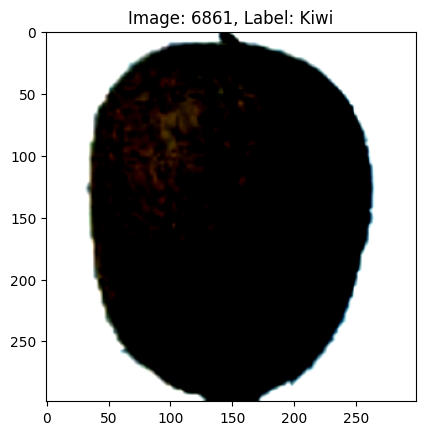

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836966..1.405142].


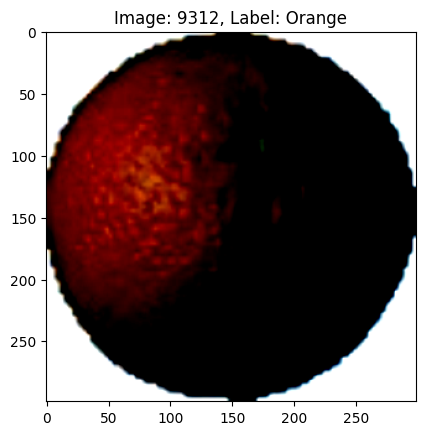

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836966..1.405142].


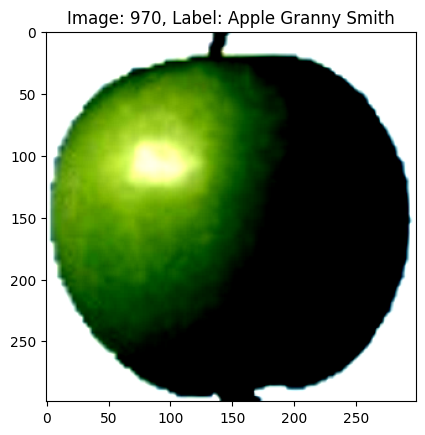

In [ ]:
import matplotlib.pyplot as plt
import random

for _ in range(3):
    random_fruit = random.randint(0, 16853)
    img, label = dataset_tensor[random_fruit]

    img = img.numpy()

    img = img.transpose((1, 2, 0))

    label_name = dataset.classes[label]

    plt.imshow(img)
    plt.title(f"Image: {random_fruit+1}, Label: {label_name}")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3259447..1.405142].


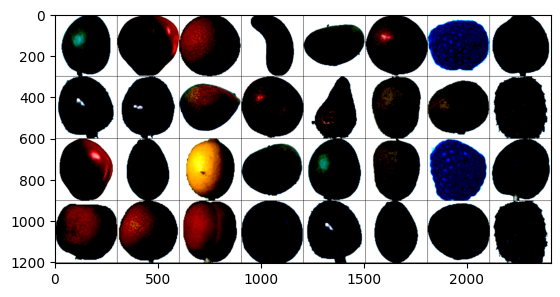

In [ ]:
from torchvision.utils import make_grid

loader = torch.utils.data.DataLoader(dataset_tensor, shuffle=True, batch_size=32)

batch, labels = next(iter(loader))

grid = make_grid(batch).permute(1, 2, 0)

plt.imshow(grid)

In [ ]:
from torchvision import models

inception = models.inception_v3(pretrained=True)
inception

C:\Users\klimk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\klimk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
class TransferLearningClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        inception = models.inception_v3(pretrained=True)

        for param in inception.parameters():
            param.requires_grad = False

        in_features = inception.fc.in_features

        inception.fc = nn.Identity()

        self.feature_extractor = inception
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(in_features, num_classes)

    def forward(self, x):
        out = self.feature_extractor(x)
        if isinstance(out, tuple):
            out = out[0]
        out = self.dropout(out)
        out = self.linear(out)
        return out

    def predict(self, data_loader, device='cpu'):
        self.eval()
        all_preds = []

        with torch.no_grad():
            for inputs in data_loader:
                inputs = inputs.to(device)
                outputs = self(inputs)
                preds = F.softmax(outputs, dim=-1)
                all_preds.append(preds.cpu().numpy())

        return np.concatenate(all_preds, axis=0)

model = TransferLearningClassifier(num_classes=len(dataset.classes)).to(device)

In [ ]:
from torchsummary import summary

summary(model, input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [ ]:
# from collections import Counter

# class_counts = Counter()
# for _, label in dataset:
#     class_counts[label] += 1

# total_samples = sum(class_counts.values())
# class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# weights = torch.tensor([class_weights[i] for i in range(len(class_counts))], dtype=torch.float32).to(device)
# weights

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, scheduler=None,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression', log_interval=1):
    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    model.to(device)

    start_time_train = time.time()

    for epoch in range(epochs):
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss'] + metrics_name}

        for batch in train_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    if func == roc_auc_score:
                        # Check if there are both classes present in y
                        if len(np.unique(y)) == 2:
                            history_train[name] += func(y, y_pred) * x.size(0)
                    else:
                        history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary':
                        y_pred_ = y_pred.round()
                    elif task == 'multiclass':
                        y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name + ['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x = batch[0].to(device)
                y = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        if func == roc_auc_score:
                            # Check if there are both classes present in y
                            if len(np.unique(y)) == 2:
                                history_val['val_' + name] += func(y, y_pred) * x.size(0)
                        else:
                            history_val['val_' + name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary':
                            y_pred_ = y_pred.round()
                        elif task == 'multiclass':
                            y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_' + name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_' + name].append(history_val['val_' + name])

        total_time_epoch = end_time_epoch - start_time_epoch

        if epoch + 1 == 1 or (epoch + 1) % log_interval == 0 or epoch + 1 == epochs:
            print(f'Epoch {epoch + 1:4d} {total_time_epoch:4.0f}sec', end='\t')
            for name in history_train:
                print(f'{name}: {history[name][-1]:10.3g}', end='\t')
                print(f"val_{name}: {history['val_' + name][-1]:10.3g}", end='\t')
            print()

        if scheduler:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(history_val['val_loss'][-1])
            else:
                scheduler.step()

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, val_loader,
                epochs=20,
                metrics=[accuracy_score],
                device=device,
                task='multiclass',
               log_interval=1)

Epoch    1  146sec	loss:        1.9	val_loss:       1.25	accuracy_score:      0.677	val_accuracy_score:      0.904	
Epoch    2   74sec	loss:      0.607	val_loss:      0.706	accuracy_score:      0.936	val_accuracy_score:       0.95	
Epoch    3   74sec	loss:      0.361	val_loss:      0.484	accuracy_score:      0.959	val_accuracy_score:      0.965	
Epoch    4   74sec	loss:      0.263	val_loss:      0.362	accuracy_score:      0.966	val_accuracy_score:      0.973	
Epoch    5   74sec	loss:      0.206	val_loss:      0.299	accuracy_score:      0.973	val_accuracy_score:      0.979	
Epoch    6   76sec	loss:      0.174	val_loss:      0.258	accuracy_score:      0.975	val_accuracy_score:      0.979	
Epoch    7   76sec	loss:      0.155	val_loss:      0.213	accuracy_score:      0.977	val_accuracy_score:      0.985	
Epoch    8   77sec	loss:      0.133	val_loss:      0.193	accuracy_score:       0.98	val_accuracy_score:      0.981	
Epoch    9   74sec	loss:      0.125	val_loss:      0.178	accuracy_score:

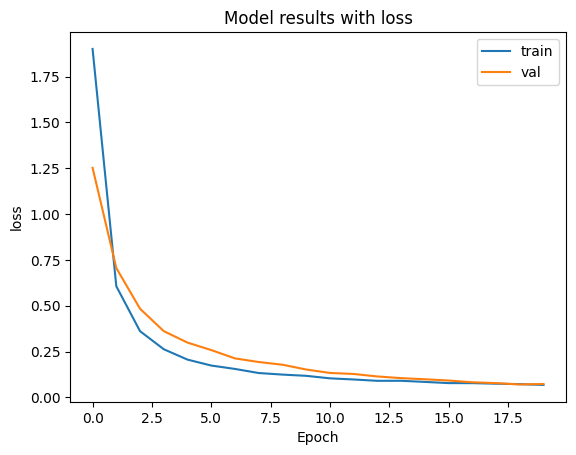

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

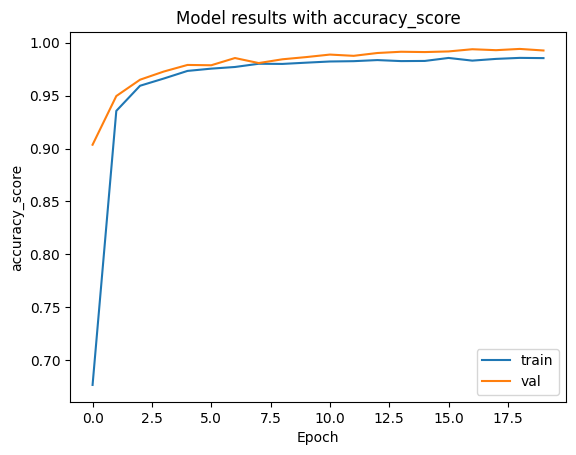

In [ ]:
plot_metric(history, 'accuracy_score')

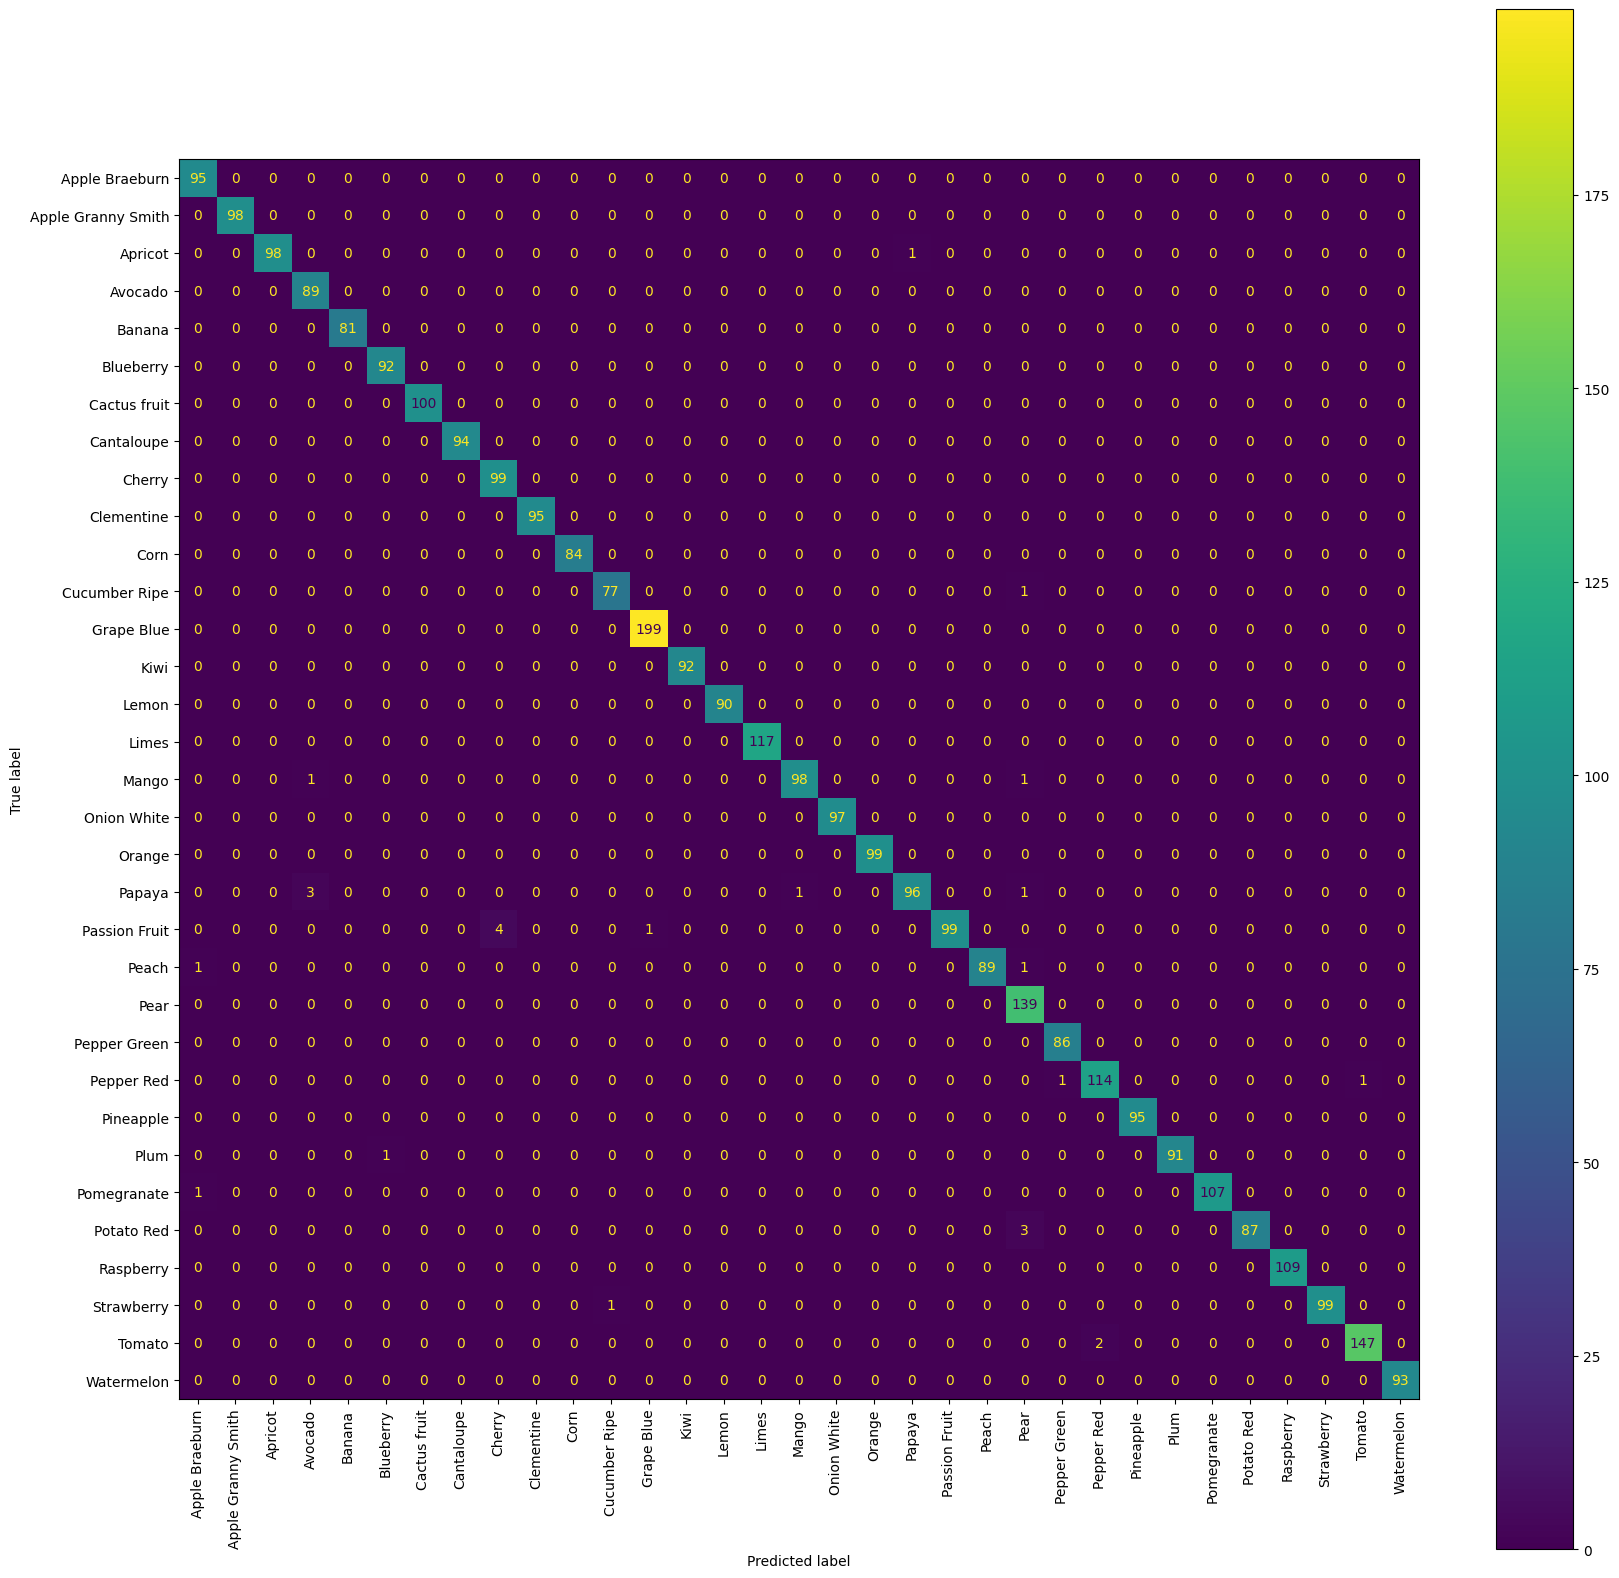

In [ ]:
model = model.to('cpu')
model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for X, y in val_loader:
        y_true.extend(y.cpu().numpy())
        X = X.to('cpu')
        y_pred_ = model(X)
        y_pred_ = y_pred_.argmax(-1).cpu().numpy()
        y_pred.extend(y_pred_)

fig, ax = plt.subplots(figsize=(20, 20))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=dataset.classes, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
model = model.to(device)
model.eval()

y_pred = []
y_test = []

with torch.no_grad():
    for X, y in val_loader:
        X = X.to(device)
        y_pred_ = model(X)
        y_pred_ = y_pred_.argmax(-1).cpu()
        y_pred.extend(y_pred_)
        y_test.extend(y)

# **Predictions on your own photos**

Calculated mean: tensor([0.0005, 0.0084, 0.0060])
Calculated std: tensor([1.0010, 0.9981, 0.9975])


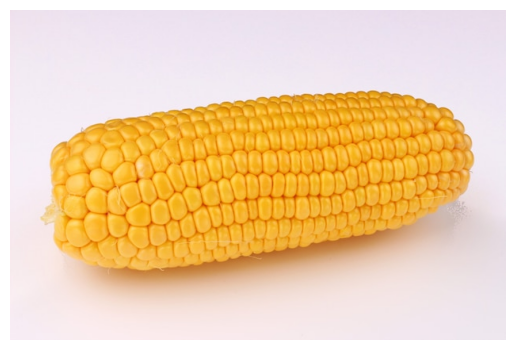

Predicted class: Corn


In [ ]:
import requests
from PIL import Image
from io import BytesIO

means = []
stds = []
for img, _ in val_data:
    means.append(torch.mean(img, [1, 2]).tolist())
    stds.append(torch.std(img, [1, 2]).tolist())

mean = torch.mean(torch.tensor(means), [0])
std = torch.mean(torch.tensor(stds), [0])

print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")

def load_and_predict(url, model, transform, device='cpu'):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    image = transform(image).unsqueeze(0)

    model = model.to(device)
    image = image.to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        prediction = output.argmax(dim=1).item()

    class_name = dataset.classes[prediction]

    return class_name

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

url = 'https://img.freepik.com/premium-photo/one-corn-maize-cobs-white-surface_406939-1408.jpg'
predicted_class = load_and_predict(url, model, transform, device=device)
print(f"Predicted class: {predicted_class}")

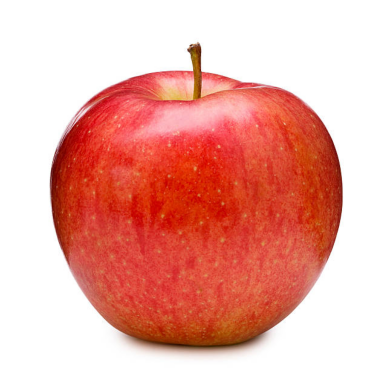

Predicted class: Apple Braeburn


In [ ]:
url1 = 'https://media.istockphoto.com/id/184276818/photo/red-apple.jpg?s=612x612&w=0&k=20&c=NvO-bLsG0DJ_7Ii8SSVoKLurzjmV0Qi4eGfn6nW3l5w%3D'
predicted_class1 = load_and_predict(url1, model, transform, device=device)
print(f"Predicted class: {predicted_class1}")

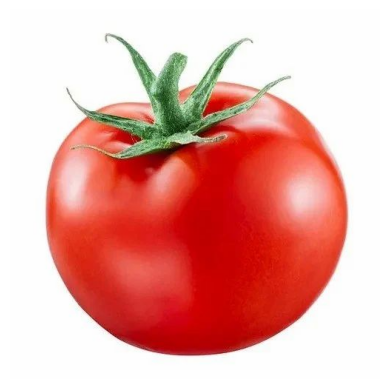

Predicted class: Tomato


In [ ]:
url2 = 'https://5.imimg.com/data5/SELLER/Default/2024/2/390027031/AR/OE/TP/99773928/tomato-500x500.jpeg'
predicted_class2 = load_and_predict(url2, model, transform, device=device)
print(f"Predicted class: {predicted_class2}")

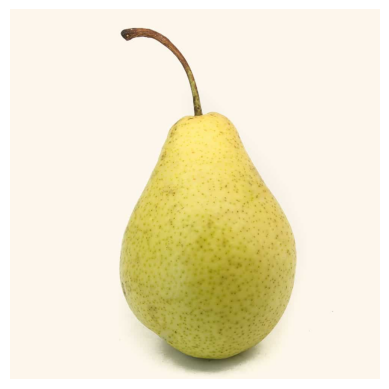

Predicted class: Pear


In [ ]:
url3 = 'https://www.hardyfruittrees.ca/app/uploads/2021/09/poirier-southworth-pear-tree-f1.jpg'
predicted_class3 = load_and_predict(url3, model, transform, device=device)
print(f"Predicted class: {predicted_class3}")